In [4]:
import pandas as pd
import numpy as np

# Load the CSV  saved on Day 1
data = pd.read_csv("../data/AAPL_sample.csv", index_col=0, parse_dates=True)

# Keep only the columns we need and ensure expected names exist
data = data[["Open","High","Low","Close","Volume"]].copy()
data.head()


C:\Users\adity\AppData\Local\Temp\ipykernel_23548\834430007.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("../data/AAPL_sample.csv", index_col=0, parse_dates=True)


,Open,High,Low,Close,Volume
Price,,,,,
Ticker,NaN,NaN,NaN,NaN,NaN
Date,NaN,NaN,NaN,NaN,NaN
1/2/2024,185.578815,186.857993,182.346189,184.081497,82488700.0
1/3/2024,182.673424,184.319491,181.890048,182.703171,58414500.0
1/4/2024,180.620803,181.552914,179.361476,180.382828,71983600.0


In [13]:
#**SMA (Simple Moving Average):** Smooths price data by averaging closing prices over a fixed window (10, 50, 200 days). Useful for spotting trend direction.


data["SMA_10"]  = data["Close"].rolling(10).mean()
data["SMA_50"]  = data["Close"].rolling(50).mean()
data["SMA_200"] = data["Close"].rolling(200).mean()


In [15]:
#**Volatility (30-day rolling std):** Measures how much returns vary over time. Higher volatility means higher risk.


ret = data["Close"].pct_change()
data["Volatility_30"] = ret.rolling(30).std()


In [16]:
#**RSI (Relative Strength Index):** Momentum oscillator ranging from 0–100. RSI above 70 signals overbought; below 30 signals oversold.


def rsi_wilder(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data["RSI_14"] = rsi_wilder(data["Close"], 14)


In [18]:
# **Bollinger Bands:** Plot upper/lower bands around a moving average. Bands widen with volatility; price touching bands often signals overbought/oversold.

win = 20
mid = data["Close"].rolling(win).mean()
std = data["Close"].rolling(win).std()
data["BB_MID"]   = mid
data["BB_UPPER"] = mid + 2*std
data["BB_LOWER"] = mid - 2*std

# ATR(14) ATR (Average True Range): Captures average trading range over 14 days, accounting for gaps. Useful for position sizing and stop-loss levels.
high, low, close = data["High"], data["Low"], data["Close"]
tr = pd.concat([
    (high - low),
    (high - close.shift()).abs(),
    (low - close.shift()).abs()
], axis=1).max(axis=1)
data["ATR_14"] = tr.rolling(14).mean()


In [19]:
# Indicators introduce NaNs at the start (rolling windows) — keep both versions
enriched_full = data.copy()
enriched = data.dropna().copy()

enriched.tail(3), enriched.shape


(                  Open        High         Low       Close      Volume  \
 Price                                                                    
 12/26/2024  257.276679  259.179926  256.718662  258.103729  27237100.0   
 12/27/2024  256.917949  257.784897  252.164833  254.685883  42355300.0   
 12/30/2024  251.337769  252.603281  249.863009  251.307877  35557500.0   
 
                 SMA_10      SMA_50     SMA_200  Volatility_30     RSI_14  \
 Price                                                                      
 12/26/2024  251.649666  235.495564  211.097456       0.008575  76.452850   
 12/27/2024  252.409964  235.975156  211.521336       0.009190  67.626275   
 12/30/2024  252.815524  236.379822  211.919042       0.009546  60.225586   
 
                 BB_MID    BB_UPPER    BB_LOWER    ATR_14  
 Price                                                     
 12/26/2024  246.616033  259.723060  233.509006  4.107561  
 12/27/2024  247.645379  259.813298  235.477460  4.35026

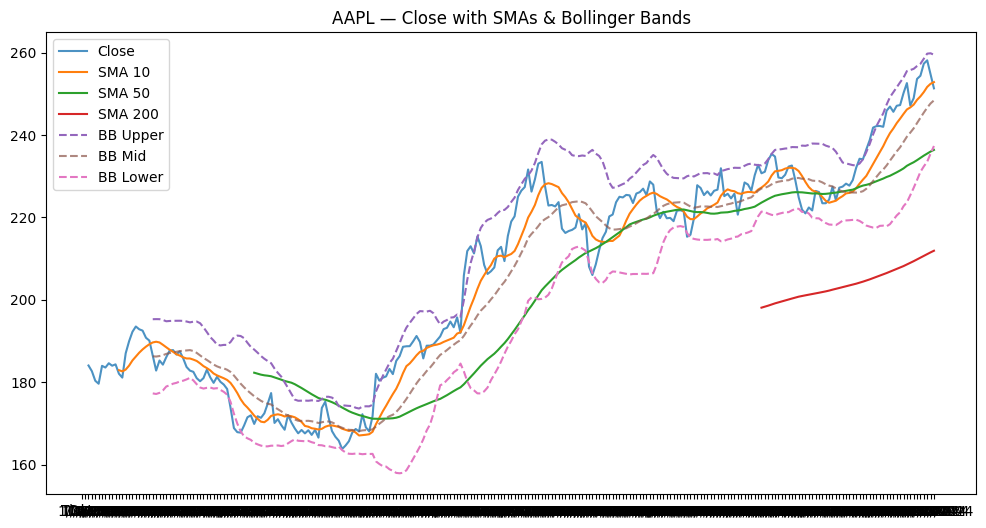

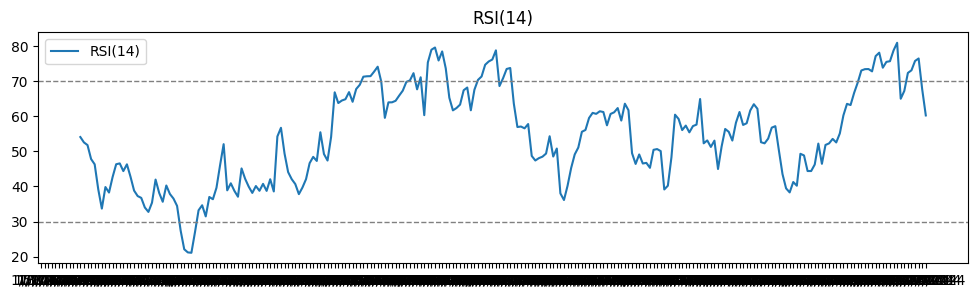

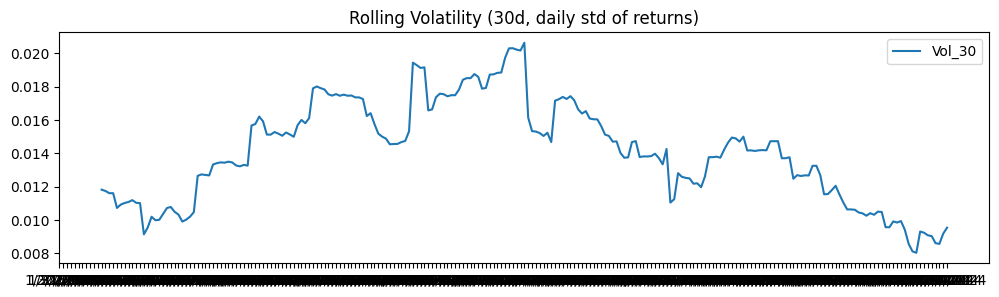

In [20]:
import matplotlib.pyplot as plt

# Price + SMAs + Bollinger
plt.figure(figsize=(12,6))
plt.plot(enriched_full.index, enriched_full["Close"], label="Close", alpha=0.8)
plt.plot(enriched_full.index, enriched_full["SMA_10"], label="SMA 10")
plt.plot(enriched_full.index, enriched_full["SMA_50"], label="SMA 50")
plt.plot(enriched_full.index, enriched_full["SMA_200"], label="SMA 200")
plt.plot(enriched_full.index, enriched_full["BB_UPPER"], label="BB Upper", linestyle="--")
plt.plot(enriched_full.index, enriched_full["BB_MID"],   label="BB Mid", linestyle="--", alpha=0.7)
plt.plot(enriched_full.index, enriched_full["BB_LOWER"], label="BB Lower", linestyle="--")
plt.title("AAPL — Close with SMAs & Bollinger Bands")
plt.legend()
plt.show()

# RSI
plt.figure(figsize=(12,3))
plt.plot(enriched_full.index, enriched_full["RSI_14"], label="RSI(14)")
plt.axhline(70, color="gray", linestyle="--", linewidth=1)
plt.axhline(30, color="gray", linestyle="--", linewidth=1)
plt.title("RSI(14)")
plt.legend()
plt.show()

# Volatility (30d rolling std of returns)
plt.figure(figsize=(12,3))
plt.plot(enriched_full.index, enriched_full["Volatility_30"], label="Vol_30")
plt.title("Rolling Volatility (30d, daily std of returns)")
plt.legend()
plt.show()


In [21]:
# Save both: full (with NaNs) for transparency, and cleaned for modeling
enriched_full.to_csv("../data/AAPL_enriched_full.csv")
enriched.to_csv("../data/AAPL_enriched.csv")
print("Saved: /data/AAPL_enriched_full.csv and /data/AAPL_enriched.csv")


Saved: /data/AAPL_enriched_full.csv and /data/AAPL_enriched.csv
